In [1]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torch.nn
from torchvision import transforms
import PIL
import kornia
import numpy as np

In [2]:
# Load the trained model 
#model2 = torch.load('./CFExp/weights20.pt')
# Set the model to evaluate mode
#model2.eval()
#model = torch.load('./CFExp/weights.pt', map_location= 'cpu')
model0 = torch.load('./CFExp/weights.pt')
#model0 = torch.jit.load('./traced_gray.pt')
# Set the model to evaluate mode
model0.eval()
model2 = model0

In [3]:
# wrap the output as a tuple, so can run through torchscript
class wrapper(torch.nn.Module):
    def __init__(self, model):
        super(wrapper, self).__init__()
        self.model = model
    
    def forward(self, input):
        results = []
        output = self.model(input)
        for k, v in output.items():
            results.append(v)
        return tuple(results)

model2 = wrapper(model0)

In [81]:
# Read the log file using pandas into a dataframe
df = pd.read_csv('./CFExp/log.csv')

### Training and testing loss, f1_score and auroc values for the model trained on the CrackForest dataset

In [4]:
# Plot all the values with respect to the epochs
#df.plot(x='epoch',figsize=(15,8));

In [14]:
print(df[['Train_auroc','Test_auroc']].max())

Train_auroc    0.951369
Test_auroc     0.940013
dtype: float64


In [23]:
im0 = cv2.imread(f'testwire\images\{ino:04d}.png', cv2.IMREAD_GRAYSCALE)
im1 = cv2.imread(f'./testwire/images/{ino:04d}.png')
len(im0.shape)

2

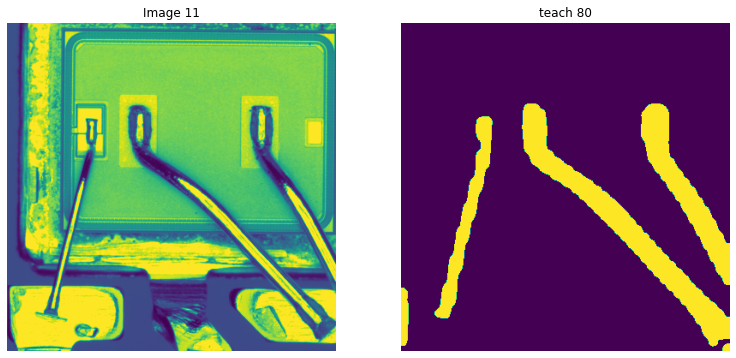

In [4]:
# Plot the input image, and output
plt.figure(figsize=(20,20));
ino = 11
# Read  a sample image and mask from the data-set
isGray = True # set this flag as needed
if isGray:
    im0 = cv2.imread(f'./testwire/images/{ino:04d}.png', cv2.IMREAD_GRAYSCALE)
    im0 = np.expand_dims(im0,axis=-1)
else:
    im0 = cv2.imread(f'./testwire/images/{ino:04d}.png')
    
rows, cols = im0.shape[0], im0.shape[1]
if isGray:
    img = im0.transpose(2,0,1).reshape(1,1,rows,cols)
else:
    img = im0.transpose(2,0,1).reshape(1,3,rows,cols)
    
input1 = torch.from_numpy(img).type(torch.cuda.FloatTensor)/255
with torch.no_grad():
    a = model2(input1)

plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title(f'Image {ino}')
plt.axis('off');
plt.subplot(132);
cc = torch.sigmoid(a[0])
cc = a[0]
dd = cc.cpu().detach().numpy()[0][0]>0.2
plt.imshow(dd);
plt.title('teach 80')
plt.axis('off');
#plt.subplot(133);
#plt.imshow(b['out'].cpu().detach().numpy()[0][0]>0.2);
#plt.title('teach 20')
#plt.axis('off');

In [5]:
import time
t1 = time.time()
input1 = torch.from_numpy(img).type(torch.cuda.FloatTensor)/255
t2 = time.time()
with torch.no_grad():
    a = model2(input1)
torch.cuda.synchronize()
t3 = time.time()
t2 - t1, t3-t2

(0.001995086669921875, 0.05485272407531738)

In [5]:
	traced_script_module = torch.jit.trace(model2, input1)
	traced_script_module.save("traced_gray.pt")


In [99]:
transs = []
transs.append(kornia.Hflip())
transs.append(kornia.Hflip())
transs.append(kornia.Translate({4,5}))


In [100]:
transs

[Hflip, Hflip, Translate()]

In [141]:
a = torch.tensor([23.0])
a = a.cuda()
a

tensor([23.], device='cuda:0')

In [153]:
a = torch.tensor([3,4])
b = torch.tensor(3)
b = b.repeat(2)
a, b

(tensor([3, 4]), tensor([3, 3]))

In [145]:
b = a.repeat(3, 1)
b.shape, b


(torch.Size([3, 2]),
 tensor([[3, 4],
         [3, 4],
         [3, 4]]))